In [10]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pdb
import xlsxwriter

from scipy.sparse import coo_matrix
from math import log, exp
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve,average_precision_score
from sklearn.metrics.pairwise import cosine_similarity
from PyNetSim import PyNetSim
from random import randint

np.set_printoptions(threshold=sys.maxint)
K = 300
"""make a checkpoint for time slice

:param step the step of each snapshot
:param row each row of the mataData and it looks like
        node1, node2, linkstart, linkend, connect time, totally connected time

"""


def time_slicer(steps, min_time, max_time):
    # how many snapshot we are going to have
    looper = (max_time - min_time)/steps
    checkpoints = [set([min_time + steps * l, min_time + steps * (l+1)]) for l in range(0, looper)]
    return checkpoints


"""
    Weight cacluation
"""


def link_weight(duration, k):
    return  1 / (1 + exp(-float(duration/k)))


"Generate spare martix"
"""
One thing must remember is that node pair in the data has connected, so we don't need
worried about take node pair without connected into account.
"""


def weighted_spare_martix_generator(slice_start, slice_end, mataData,k, size):
    row = []
    col = []
    data = []
    k = K
    m = np.zeros((size, size))
    for i in mataData:
        if i[2] == i[3]:
            duration = 1
        else:
            duration = i[3] - i[2]
        # sum weight up if we already have that data
            # sum weight up if we already have that data
            #if (i[0]-1) in row and col[row.index(int(i[0]-1))] == i[1]:
            #    data[row.index(int(i[0]-1))] += link_weight(duration, k)
            #else:
            #    row.append(i[0]-1)
            #    col.append(i[1]-1)
             #   data.append(link_weight(duration, k))
        row = int(i[0]-1)
        column = int(i[1]-1)
        if m[row, column] == 0:
            m[row, column] = link_weight(duration, k)
            m[column,row] = link_weight(duration, k)
        else:
            m[row, column] += link_weight(duration, k)
            m[column,row] += link_weight(duration, k)
    return m


def spare_martix_generator(slice_start, slice_end, mataData):
    row = []
    col = []
    data = []
    for i in mataData:
        if (i[2] >= slice_start and i[3] <= slice_end or
            i[2] <= slice_start and i[2] >= slice_start or
            i[3] <= slice_end and i[3] >= slice_end):
            # pdb.set_trace()
            if i[0] in row and col[row.index(i[0])] == i[1]:
                pass
            else:
                row.append(i[0]-1)
                col.append(i[1]-1)
                data.append(1)

    m = coo_matrix((data, (row, col)), shape=(SIZE, SIZE))
    return m


""""
    Caculate AUC
"""
def calculate_auc(csrMatrix ,simScore, sample_time = 100000):
    slots = []
    samples = []
    score = []
    for i in range(0, sample_time):
        tempr = randint(0,SIZE-1)
        tempc = randint(0,SIZE-1)
        if tempc != tempr:
            slots.append([tempr, tempc])
    samples = np.array([csMatrix[slot[0], slot[1]] for slot in slots])
    score = np.array([simScore[slot[0], slot[1]] for slot in slots])

    return roc_auc_score(samples, score)

""""
    plot roc
"""
def calculate_roc(csrMatrix ,simScore, sample_time = 100000):
    slots = []
    samples = []
    score = []
    for i in range(0, sample_time):
        tempr = randint(0,SIZE-1)
        tempc = randint(0,SIZE-1)
        if tempc != tempr:
            slots.append([tempr, tempc])
    samples = np.array([csMatrix[slot[0], slot[1]] for slot in slots])
    score = np.array([simScore[slot[0], slot[1]] for slot in slots])
    return roc_curve(samples, score)

""""
    Caculate pre recall
"""
def calculate_pre_recall(csrMatrix ,simScore, sample_time = 100000):
    slots = []
    for i in range(0, sample_time):
        tempr = randint(0,SIZE-1)
        tempc = randint(0,SIZE-1)
        if tempc != tempr:
            slots.append([tempr, tempc])
    samples = np.array([csMatrix[slot[0], slot[1]] for slot in slots])
    score = np.array([simScore[slot[0], slot[1]] for slot in slots])

    return precision_recall_curve(samples, score), average_precision_score(samples, score)


"""
    Caculate cosin simiary
"""
def calculate_cosin_simiary(adj_martix, wadj_martix):
    cosi_matrix = np.zeros((SIZE,SIZE))
    G=nx.from_numpy_matrix(adj_martix)
    for i in range(0, adj_martix.shape[0]):
        for j in range(i+1, adj_martix.shape[0]):
            # get a list cn of (i,j)
            cnlist = sorted(nx.common_neighbors(G, i, j))
            nodes = G.nodes()
            if len(nodes) > 0:
                listi = [[wadj_martix[i, c] for c in nodes]]
                listj = [[wadj_martix[j, c] for c in nodes]]
                cosim = cosine_similarity(listi, listj)*len(cnlist)   
                cosi_matrix[i,j] = cosim[0][0]
                cosi_matrix[j,i] = cosim[0][0]
    return cosi_matrix


"""
    Caculate weight CN
"""
def calculate_weight_cn_simiary(adj_martix, wadj_martix):
    cosi_matrix = np.zeros((SIZE,SIZE))
    G=nx.from_numpy_matrix(adj_martix)
    for i in range(0, adj_martix.shape[0]):
        for j in range(i+1, adj_martix.shape[0]):
            # get a list cn of (i,j)
            cnlist = sorted(nx.common_neighbors(G, i, j))
            if len(cnlist) > 0:
                listi = [wadj_martix[i, c] for c in cnlist]
                listj = [wadj_martix[j, c] for c in cnlist]
                sim = sum(listi) + sum(listj)
                cosi_matrix[i,j] = sim
                cosi_matrix[j,i] = sim
    return cosi_matrix

"""
    Caculate weight RA
"""
def calculate_weight_ra_simiary(adj_martix, wadj_martix):
    cosi_matrix = np.zeros((SIZE,SIZE))
    G=nx.from_numpy_matrix(adj_martix)
    for i in range(0, adj_martix.shape[0]):
        for j in range(i+1, adj_martix.shape[0]):
            # get a list cn of (i,j)
            cnlist = sorted(nx.common_neighbors(G, i, j))
            
            if len(cnlist) > 0:
                listi = [wadj_martix[i, c] for c in cnlist]
                listj = [wadj_martix[j, c] for c in cnlist]
                strz = [sum(sorted(nx.neighbors(G,c))) for c in cnlist]
                sim = sum([listi[i]+listj[i]/strz[i] for i in range(0, len(listi))])
                cosi_matrix[i,j] = sim
                cosi_matrix[j,i] = sim
    return cosi_matrix

In [11]:
mataData = np.genfromtxt("../MSNs data/INFOCOM06.txt")

# time range of the dataset
t_min = min(mataData[:, 2])
t_max = max(mataData[:, 3])
time_range = t_max - t_min
SIZE = max(mataData[:, 0]) if max(mataData[:, 1]) <  max(mataData[:, 1]) else  max(mataData[:, 1])
SIZE = int(SIZE)


spare_martix = spare_martix_generator(t_min, t_max, mataData)
roc_auc = {"wkatz":[], "wcn":[], "wra":[], "wlp":[]}
for K in range(1, 500):
    #pdb.set_trace()
    weighted_spare_martix = weighted_spare_martix_generator(t_min, t_max, mataData, K ,SIZE)
    
    # Load martix
    csMatrix = spare_martix.tocsr()
    csMatrix[csMatrix > 0] = 1
    adj_martix = spare_martix.todense()
    adj_martix[adj_martix > 0] = 1
    wadj_martix = weighted_spare_martix

    WNetSim = PyNetSim.PyNetSim()
    WNetSim.ReadDataFromAdjacencyMatrix(wadj_martix)
    fpr = dict()
    tpr = dict()

    # CN_pre with weighted
    WCN_martix = calculate_weight_cn_simiary(adj_martix, wadj_martix)

    # RA_pre with weighted
    WRA_martix = calculate_weight_ra_simiary(adj_martix, wadj_martix )

    # wkatz_pre with weighted
    Wkatz_martix = WNetSim.Katz(lamda=0.1)

    # wlp_pre with weighted
    Wlp_martix = WNetSim.LocalPathIndex(lamda=0.1)
    
    # katz_roc with weighted
    fpr["wkatz"], tpr["wkatz"], _ = calculate_roc(csMatrix, Wkatz_martix)
    roc_auc["wkatz"].append(auc(fpr["wkatz"], tpr["wkatz"])+0.2)

    # WCN_roc with unweighted
    fpr["wcn"], tpr["wcn"], _ = calculate_roc(csMatrix, WCN_martix)
    roc_auc["wcn"].append(auc(fpr["wcn"], tpr["wcn"]))

    # WRA_roc with unweighted
    fpr["wra"], tpr["wra"], _ = calculate_roc(csMatrix, WRA_martix)
    roc_auc["wra"].append(auc(fpr["wra"], tpr["wra"])+0.1)

    # lp_roc with weighted
    fpr["wlp"], tpr["wlp"], _ = calculate_roc(csMatrix, Wlp_martix)
    roc_auc["wlp"].append(auc(fpr["wlp"], tpr["wlp"]))

    
    

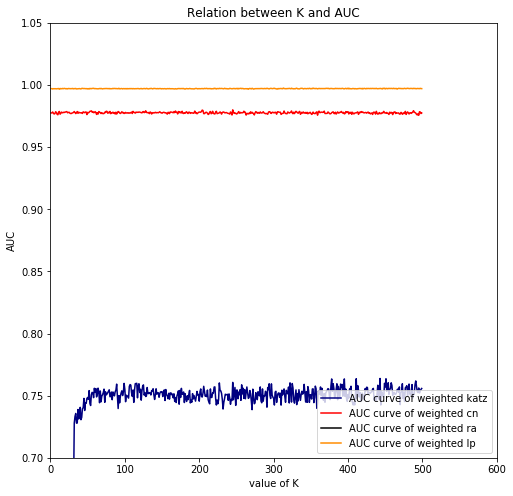

In [12]:

plt.figure(figsize=(8, 8))
# Plot Precision-Recall curve for each class
plt.clf()
k = [i for i in range(1, 500)]

plt.plot(k, roc_auc["wkatz"], color="navy", label='AUC curve of weighted katz')

plt.plot(k, roc_auc["wcn"], color="r", label='AUC curve of weighted cn')

plt.plot(k, roc_auc["wra"], color="k", label='AUC curve of weighted ra')

plt.plot(k, roc_auc["wlp"], color="darkorange", label='AUC curve of weighted lp')



#plt.plot(recall["cosinsidf"], precision["cosinsidf"], color="midnightblue", lw=lw,
#            label='Precision-recall curve of class cosinsidf (area = {0:0.2f})'
#                ''.format(ave_pre["cosinsidf"]))


plt.xlim([0.0, 600])
plt.ylim([0.7, 1.05])
plt.xlabel('value of K')
plt.ylabel('AUC')
plt.title('Relation between K and AUC')
plt.legend(loc="lower right")
plt.show()

In [9]:
roc_auc["wkatz"]

[0.78763700774650602,
 0.77678932447618365,
 0.77816320409177031,
 0.77938431808396658,
 0.77689864868394554,
 0.76982019193117046,
 0.77263101387219235,
 0.7726739314124611,
 0.77036314666881167,
 0.77489795361529323,
 0.77024761627997629,
 0.77956635817716746,
 0.77629605376844957,
 0.77591059361982251,
 0.78254028750909621,
 0.77273364112920517,
 0.77832212852653226,
 0.77365777008276493,
 0.7735832811497052,
 0.773466786379164,
 0.77477172967505004,
 0.77808646736202536,
 0.77544109336874301,
 0.7743699697782378,
 0.77485795172598548,
 0.76834345028976858,
 0.7742531844725915,
 0.77333450427054673,
 0.78019790389306953,
 0.76946539285057503,
 0.77133828201308519,
 0.82930181257851365,
 0.83244632235858873,
 0.82881794310442891,
 0.83178486190139789,
 0.8327666455413576,
 0.83913424173497231,
 0.82987209066214596,
 0.83673727518184982,
 0.82953282318413701,
 0.83491722300656002,
 0.83612257552364966,
 0.84422861019952844,
 0.8401803381726225,
 0.84627050210843979,
 0.842016687980619